In [344]:
from cogrecon.core.data_flexing.time_travel_task.time_travel_task_analytics import calculate_fd_and_lacunarity

import scipy.optimize
from pandas import Series, DataFrame
import statsmodels.formula.api as sm
import numpy as np, scipy, scipy.stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, lfilter, freqz
import copy

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

%matplotlib inline

def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    ims = []
    for image in images:
        ims.append(OffsetImage(image, zoom=zoom))
    artists = []
    for x0, y0, im in zip(x, y, ims):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def generate_random_walk(n=10000, d=2, bias=None, scaling=None, plot=True):
    if bias is None:
        bias = [0] * d
    if scaling is None:
        scaling = [1] * d
    start_pos = [0]*d
    steps = np.random.rand(n - 1, len(start_pos)) * 2 - [[1]*len(start_pos)]*(n - 1)
    random_walk = [start_pos]
    for s in steps:
        random_walk.append(random_walk[-1] + s + bias)
    if plot:
        if d == 1 or d == 2:
            plt.plot(*np.transpose(random_walk))
        if d == 3:
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            ax.plot(*np.transpose(random_walk), label='parametric curve')

        plt.show()
    return random_walk

def filter_walk(walk, order=6, fs=30.0, cutoff=3.667):
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

    # Filter the data, and plot both the original and filtered signals.
    return np.transpose([butter_lowpass_filter(dim, cutoff, fs, order) for dim in np.transpose(walk)])

def generate_param_list_with_min_max(path_length=10000, bias=None, scaling=None, filter_cutoff=None, iterations=50, window=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):
    fds = []
    ls = []
    extreme_fd_walk = [None, None]
    extreme_l_walk = [None, None]
    for _ in range(0, iterations):
        walk = generate_random_walk(n=path_length, plot=False, bias=bias, scaling=scaling)
        if filter_cutoff is not None:
            walk = filter_walk(walk, cutoff=filter_cutoff)
        fd, l = calculate_fd_and_lacunarity(walk, window)
        if len(fds) > 0:
            if fd < min(fds):
                extreme_fd_walk[0] = walk[:]
            if fd > max(fds):
                extreme_fd_walk[1] = walk[:]
        else:
            extreme_fd_walk[0] = walk[:]
            extreme_fd_walk[1] = walk[:]
        if len(ls) > 0:
            if l < min(ls):
                extreme_l_walk[0] = walk[:]
            if l > max(ls):
                extreme_l_walk[1] = walk[:]
        else:
            extreme_l_walk[0] = walk[:]
            extreme_l_walk[1] = walk[:]
        fds.append(fd)
        ls.append(l)
    results = np.transpose([fds, ls])
    return results, extreme_fd_walk, extreme_l_walk

def plot_path(path, window=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], title=''):
    fd, l = calculate_fd_and_lacunarity(path, window)
    plt.title(title + ' fd={0}, l={1}'.format(fd, l))
    plt.plot(*np.transpose(path))
    plt.show()
    
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_plot_image_data(path, window=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.set_axis_off()
    ax.plot(*np.transpose(path))
    canvas.draw()
    dims = fig.get_size_inches()*fig.dpi
    image = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
    return np.array(image).reshape((int(dims[1]), int(dims[0]), 3))

def replace_white_with_alpha(img):
    s = img.shape
    length = s[0] * s[1]
    append_array = np.array([[[np.uint8(255)] for _ in range(0, s[1])] for _ in range(0, s[0])])
    alpha_img = np.append(np.array(img), append_array, axis=2)
    for row in alpha_img:
        for pixel in row:
            if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                pixel[3] = np.uint8(0)
            else:
                pixel[3] = np.uint8(255)
    return alpha_img

import numpy as np
import scipy.optimize
def calculate_fd_and_lacunarity_scales(data, indicies=None):
    scale_range = 20
    r = np.array([2.0 ** (scale_range / 2) / (2.0 ** i) for i in range(scale_range, 0, -1)])  # Powers of 2 around 0
    N = [count_boxes(data, ri) for ri in r]
    Nlog = np.log(N)
    ste = np.std(Nlog) / np.sqrt(len(data))
    if indicies is None:
        indicies = [idx for idx, n in enumerate(Nlog) if (not n <= (min(Nlog) + ste) and not n >= (max(Nlog) - ste))]
    N = np.take(N, indicies)
    r = np.take(r, indicies)

    def linear_function(x, A, Df):
        return Df * x + A

    popt, pcov = scipy.optimize.curve_fit(linear_function, np.log(1. / r), np.log(N))
    lacunarity, fd = popt

    return fd, lacunarity, indicies

def generate_scales_list(path_length=10000, bias=None, scaling=None, filter_cutoff=None, iterations=50, window=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):
    ss = []
    for _ in range(0, iterations):
        walk = generate_random_walk(n=path_length, plot=False, bias=bias, scaling=scaling)
        if filter_cutoff is not None:
            walk = filter_walk(walk, cutoff=filter_cutoff)
        fd, l, s = calculate_fd_and_lacunarity_scales(walk)
        ss.append(s)
    return ss

def count_boxes(data, scale):
    boxed_path = np.floor(np.divide(data, scale))
    unique = np.unique(boxed_path, axis=0)
    filled_boxes = len(unique)
    return filled_boxes

In [355]:
iterations = 50
path_length = 10000
window = [7, 8, 9, 10, 11, 12, 13, 14, 15]
cutoffs = [None, 0.4, 0.2, 0.08]
labels = ['Random', 'Light Filter', 'Medium Filter', 'Heavy Filter']
results = [generate_param_list_with_min_max(path_length=path_length, filter_cutoff=cutoff, iterations=iterations, window=window) for cutoff in cutoffs]
pts, fd_walks, l_walks = np.transpose(results)

In [346]:
scale_results = [generate_scales_list(path_length=path_length, filter_cutoff=cutoff, iterations=iterations, window=window) for cutoff in cutoffs]

In [354]:
print(sorted(np.array([[(min(ss), max(ss)) for ss in s] for s in scale_results]).flatten()))

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

In [356]:
paths = [walk for fd_walk in fd_walks for walk in fd_walk]
img_pts = [calculate_fd_and_lacunarity(path, window) for path in paths]
images = [replace_white_with_alpha(get_plot_image_data(walk)) for walk in paths]

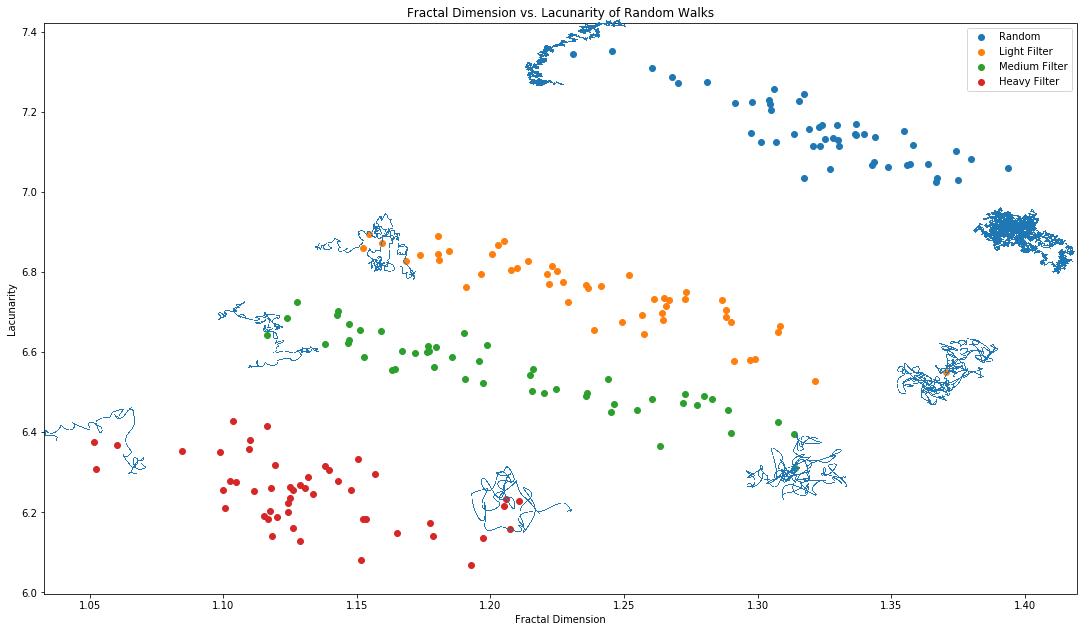

In [357]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(18.5, 10.5)
plt.title('Fractal Dimension vs. Lacunarity of Random Walks')
plt.xlabel('Fractal Dimension')
plt.ylabel('Lacunarity')
for pt, label in zip(pts, labels):
    ax.scatter(*np.transpose(pt), label=label)
imscatter(*np.transpose(img_pts), images=images, zoom=0.33)
plt.legend()
plt.show()

In [320]:
from tqdm import tqdm
from cogrecon.core.data_flexing.time_travel_task.time_travel_task_binary_reader import find_data_files_in_directory, read_binary_file

search_directory = r'C:\Users\Kevin\Documents\GitHub\msl-iposition-pipeline\examples\saved_data\Paper Data (cleaned)'
# file_regex="\d\d\d_\d_1_\d_\d\d\d\d-\d\d-\d\d_\d\d-\d\d-\d\d.dat"
file_regex="\d\d\d_\d_\d_\d_\d\d\d\d-\d\d-\d\d_\d\d-\d\d-\d\d.dat"
files = find_data_files_in_directory(search_directory, file_regex=file_regex)
ex = [None, None, None, None] # top left, top right, bottom left, bottom right
ex_vals = [[None, None], [None, None], [None, None], [None, None]]
participant_pts = []
for path in tqdm(files):
    iterations = read_binary_file(path)
    spaceline = [[i['x'], i['z']] for i in iterations]
    fd, l = calculate_fd_and_lacunarity(spaceline, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
    participant_pts.append([fd, l])
    if ex[0] is None or (fd < ex_vals[0][0] and l > ex_vals[0][1]):
        ex_vals[0] = [fd, l]
        ex[0] = path[:]
    if ex[1] is None or (fd > ex_vals[1][0] and l > ex_vals[1][1]):
        ex_vals[1] = [fd, l]
        ex[1] = path[:]
    if ex[2] is None or (fd < ex_vals[2][0] and l < ex_vals[2][1]):
        ex_vals[2] = [fd, l]
        ex[2] = path[:]
    if ex[3] is None or (fd < ex_vals[3][0] and l > ex_vals[3][1]):
        ex_vals[3] = [fd, l]
        ex[3] = path[:]

2018-02-03 16:29:04 DESKTOP-LKC15NF root[15860] INFO Found 387 data files in 0.0620000362396 seconds.
100%|██████████████████████████████████████████████████████████████████████████████| 387/387 [1:08:17<00:00, 10.59s/it]



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Program Files\Anaconda3\envs\iposition\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\Program Files\Anaconda3\envs\iposition\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Program Files\Anaconda3\envs\iposition\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.75s/it]


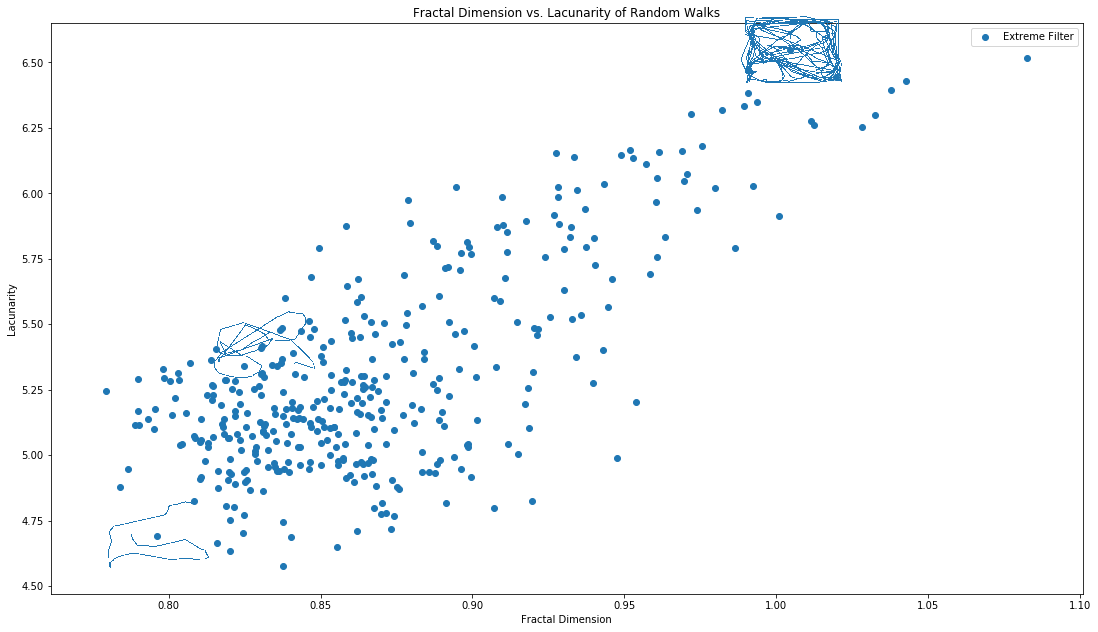

In [329]:
paths = []
window = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for path in tqdm(ex):
    iterations = read_binary_file(path)
    spaceline = [[i['x'], i['z']] for i in iterations]
    paths.append(spaceline)

In [336]:
paths = paths[1:]
img_pts = [calculate_fd_and_lacunarity(path, window) for path in paths]
images = [replace_white_with_alpha(get_plot_image_data(walk)) for walk in paths]

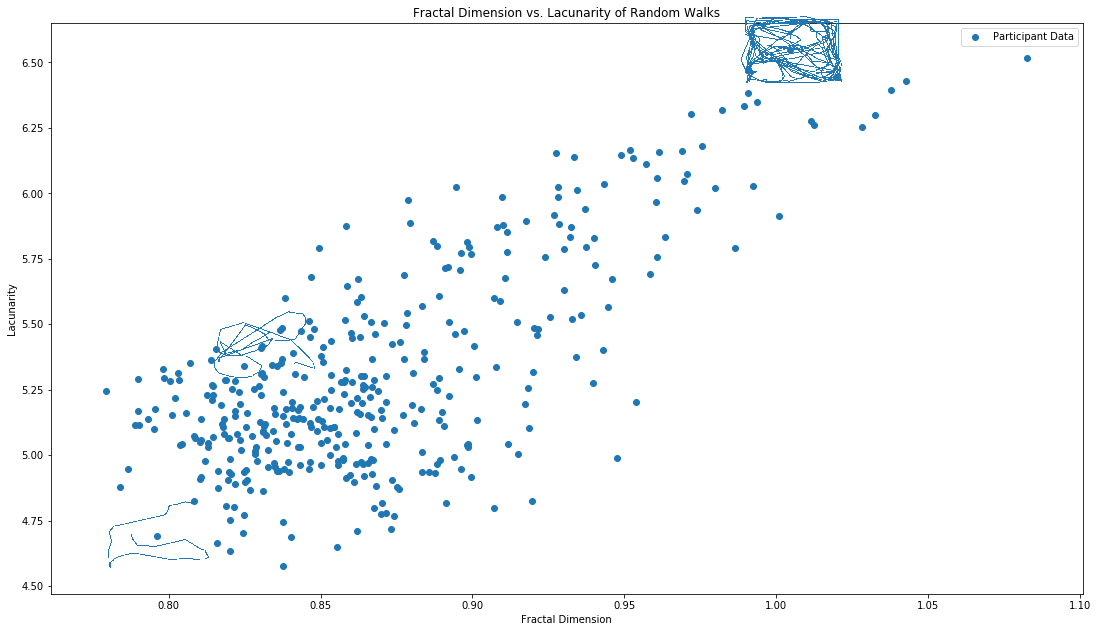

In [338]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(18.5, 10.5)
plt.title('Fractal Dimension vs. Lacunarity of Random Walks')
plt.xlabel('Fractal Dimension')
plt.ylabel('Lacunarity')
# for pt, label in zip(pts, labels):
ax.scatter(*np.transpose(participant_pts), label='Participant Data')
imscatter(*np.transpose(img_pts), images=images, zoom=0.33)
plt.legend()
plt.show()